In [10]:
#The purpose of this notebook is to implement a butterworth high pass IIR filter

import math
import cmath
import numpy
import scipy
from scipy import signal
import matplotlib.pyplot as plt

fp = 1200 #pass band frequency
fs = 1500 #stop band frequency
Ap = 3 #Pass band maximum attenuation
As = 20 #Stop band minimum attenuation
Wp = 1
Ws = fs/fp
#Ws = -fp/fs

#First compute the filter order from the input parameters

N = math.log((10**(As/10)-1)/(10**(Ap/10)-1))/(2*math.log(Ws))

Order = math.ceil(N)

Order

11

In [11]:
#Now find the pole locations

s = [(1+1j)]*Order

m = 0
while m < Order:
    s[m] = cmath.exp(1j*(((math.pi+2*math.pi*m)/(2*Order))+(math.pi/2)))
    m += 1
    
s

[(-0.142314838273285+0.9898214418809328j),
 (-0.4154150130018863+0.9096319953545184j),
 (-0.654860733945285+0.7557495743542583j),
 (-0.8412535328311811+0.5406408174555978j),
 (-0.9594929736144974+0.28173255684142967j),
 (-1+1.2246467991473532e-16j),
 (-0.9594929736144975-0.2817325568414294j),
 (-0.8412535328311814-0.5406408174555972j),
 (-0.6548607339452852-0.7557495743542582j),
 (-0.41541501300188716-0.909631995354518j),
 (-0.14231483827328523-0.9898214418809327j)]

[(-1707.4094562733912-11875.293612352129j),
 (-4983.904209027932-10913.227948969854j),
 (-7856.632683186651-9067.037460627724j),
 (-10092.863502547278-6486.289520973621j),
 (-11511.430545501991-3380.060979779339j),
 (-11997.409946773641-1.4692589689374957e-12j),
 (-11511.430545501991+3380.060979779336j),
 (-10092.863502547281+6486.289520973614j),
 (-7856.632683186652+9067.037460627722j),
 (-4983.904209027944+10913.22794896985j),
 (-1707.4094562733942+11875.293612352129j)]

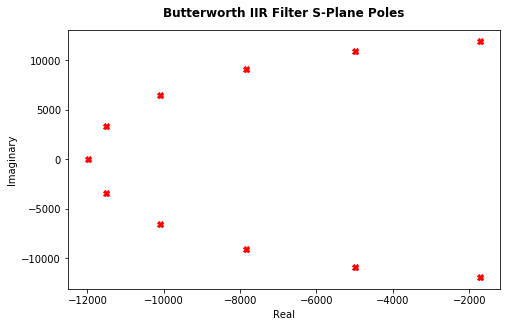

In [12]:
#Now need to rescale and frequency shift poles

As0 = 10*math.log10(Ws**(2*Order)*(10**(Ap/10)-1)+1)

Wc = Ws/((10**(As0/10)-1)**(1/(2*Order)))

s0 = [i * Wc for i in s]

#I must prewarp to account for bilinear transform warping.

#I will need a sampling frequency for this part of the process, for now just assume something sufficiently
#large so as to not cause a problem, say 4X stop band frequency

fsamp = 4*fs

fc = (fsamp/math.pi)*math.tan(math.pi*fs/fsamp)

# use s for non-warped and s0 for warped, divide 2*pi*fc by i to convert to high pass
s1 = [2*math.pi*(fc) / i for i in s0]

sreal = [i.real for i in s1]
simag = [i.imag for i in s1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(sreal,simag,'rX')
#ax.set_xlim(-10,10)

fig.suptitle('Butterworth IIR Filter S-Plane Poles', fontweight='bold') 
ax.set_xlabel('Real') 
ax.set_ylabel('Imaginary') 
s1

[1.0,
 -0.0015065577301729073,
 1.4792945325771671,
 -0.00173972081943618,
 0.7013130664861877,
 -0.0006115848005290448,
 0.1262134514212163,
 -7.493115586152172e-05,
 0.007898393095335002,
 -2.6818410814163486e-06,
 0.00011527020615762056,
 -1.244115338416473e-08]

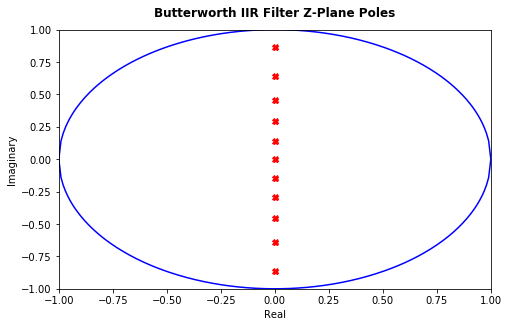

In [13]:
#Ok, now I need to start the bilinear transform.  

m = 0
s2 = [0]*Order
while m < Order:
    #s2[m] = (1+(s1[m]/(2*fsamp)))/(1-(s1[m]/(2*fsamp)))
    s2[m] = (2*fsamp + s1[m])/(2*fsamp - s1[m])
    m += 1
    
#Need to calculate the zeros

z = [1]*Order

z0 = list(numpy.poly(z))

#now need coefficients of poles

s3 = numpy.poly(s2)

s4 = [i.real for i in s3]

m = 0
z1 = [0]*len(z0)
s5 = [0]*len(s4)
while m < len(s5):
    z1[m] = z0[m]*(-1)**m
    s5[m] = s4[m]*(-1)**m
    m += 1

K = sum(z1)/sum(s5)

z0 = [i / K for i in z0]

sreal = []
simag = []
sreal = [i.real for i in s2]
simag = [i.imag for i in s2]

fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(sreal,simag,'rX')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

circle = [0]*201
m = 0
while m < len(circle):
    circle[m] = m
    m+=1
circlex = []
circlex = [(-1+i/100) for i in circle]
circley = [(1-i**2)**.5 for i in circlex]
circley2 = [-(1-i**2)**.5 for i in circlex]
ax.plot(circlex,circley,'b')
ax.plot(circlex,circley2,'b')

fig.suptitle('Butterworth IIR Filter Z-Plane Poles', fontweight='bold') 
ax.set_xlabel('Real') 
ax.set_ylabel('Imaginary')
s4

Text(0, 0.5, 'Amplitude')

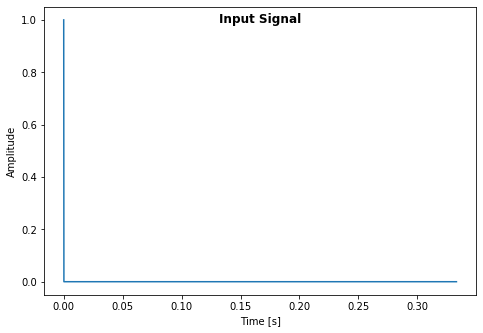

In [14]:
#Generate a waveform to use for testing the filter

m = 0
waveform = []
while m < 2000:
    #waveform.append((math.sin(2*math.pi*800/fsamp*m))+(math.sin(2*math.pi*1600/fsamp*m))+(math.sin(2*math.pi*2400/fsamp*m))+(math.sin(2*math.pi*3200/fsamp*m))+(math.sin(2*math.pi*4000/fsamp*m)))
    waveform.append(0)
    #waveform.append(1+math.sin(2*math.pi*2000/fsamp*m))
    m += 1
waveaxis = []
m = 0
while m < len(waveform):
    waveaxis.append(m/fsamp)
    m += 1

waveform[0] = 1
#waveform[50] = 1
#waveform[70] = 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(waveaxis,waveform)

fig.suptitle('Input Signal', fontweight='bold') 
ax.set_xlabel('Time [s]') 
ax.set_ylabel('Amplitude') 



Text(0, 0.5, 'Amplitude')

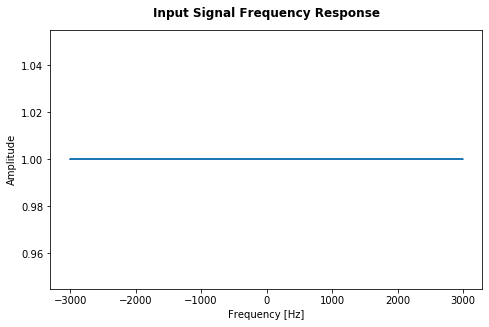

In [15]:
#Test waveform frequency response
wavefreq = abs(scipy.fft(waveform))
freqaxis = []

freqaxis = list(numpy.fft.fftfreq(len(waveform), d=1/fsamp))

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(freqaxis,wavefreq)

fig.suptitle('Input Signal Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude') 

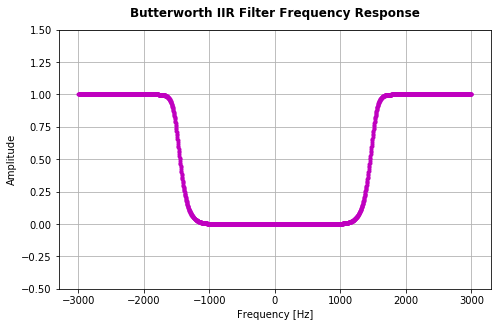

In [16]:
#Now must run it through filter.

m = 0
ataps = z0
btaps = s4
btaps[0] = 0
outmem = [0]*len(s4)
output = []
accum = 0
accum2 = 0
while m < len(waveform):
    #calculate first, then shift in new values
    n = 0
    accum = 0
    outmem = [(waveform[m]+accum2)] + outmem[:(len(outmem)-1)]
    accum2 = 0
    while n < (len(s4)):
        if (m-n) >= 0:
            accum += ataps[n]*waveform[m-n]
        n += 1
    n = 1
    while n < (len(s4)):
        if (m-n) >= 0:
            accum -= btaps[n]*output[m-n]
        n += 1
    output.append(accum)

    m += 1
       
wavefreq = list((abs(scipy.fft(output))))
freqaxis = []

freqaxis = list(numpy.fft.fftfreq(len(wavefreq), d=1/fsamp))

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(freqaxis,wavefreq,'m.')

fig.suptitle('Butterworth IIR Filter Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude') 
ax.set_ylim(-.5,1.5)
ax.grid()


C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


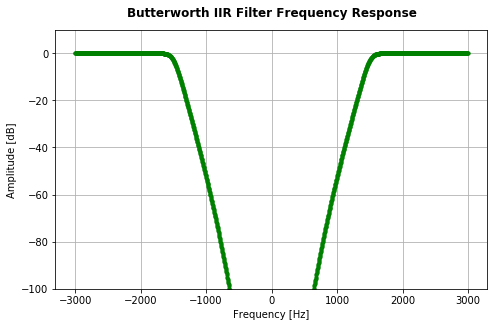

In [17]:
#plot in dB
wavefreq = [numpy.log10(i) * 20 for i in wavefreq]

fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(freqaxis,wavefreq,'g.')

fig.suptitle('Butterworth IIR Filter Frequency Response', fontweight='bold') 
ax.set_xlabel('Frequency [Hz]') 
ax.set_ylabel('Amplitude [dB]') 
ax.set_ylim(-100,10)
ax.grid()

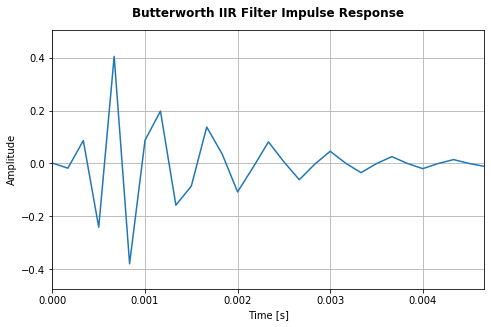

In [18]:
#Time domain plot
timeaxis = list(range(len(output)))
timeaxis = [i/fsamp for i in timeaxis]
fig.clear()
fig = plt.figure()
ax = fig.add_axes([0,0,1,.9])
ax.plot(timeaxis,output)


fig.suptitle('Butterworth IIR Filter Impulse Response', fontweight='bold') 
ax.set_xlabel('Time [s]') 
ax.set_ylabel('Amplitude') 
ax.set_ylim((min(output)+.25*min(output)),(max(output)+.25*max(output)))
ax.set_xlim(0,(7*timeaxis[output.index(max(output))]))
ax.grid()